# Creating Training Data from Sentinel-2 and Sentinel-3 OLCI Data
In our previous session, we explored the method of retrieving colocated Sentinel-2 optical data alongside Sentinel-3 OLCI data. Building upon that foundation, this week’s focus shifts towards the processing these datasets into a ML dataset we can use for regression. Our ultimate goal is to achieve pixel-level colocation between the datasets, and the application of regression techniques in task of predicitng sea ice concentration from S3/S2.

## Step 0: Importing Sentinel-2 and Sentinel-3 OLCI Data
Now, we reintroduce some previously utilised code with a pivotal objective: to import raw data and transform it into a format amenable to our analysis requirements. Given the extensive memory demands of this operation, we recommend a conceptual understanding of the process rather than direct execution.

In [ ]:
! pip install rasterio
! pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

```python

#This takes ~60 seconds and ~2Gb RAM

import rasterio
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from pyproj import Proj, transform

# Paths to the band images
path = '/content/drive/MyDrive/GEOL0069/2425/Week 5/' # You need to specify the path
base_path = "S2A_MSIL1C_20190301T235611_N0207_R116_T01WCU_20190302T014622.SAFE/GRANULE/L1C_T01WCU_A019275_20190301T235610/IMG_DATA/"
bands_paths = {
    'B4': path + base_path + 'T01WCU_20190301T235611_B04.jp2',
    'B3': path + base_path + 'T01WCU_20190301T235611_B03.jp2',
    'B2': path + base_path + 'T01WCU_20190301T235611_B02.jp2'
}

# Read and stack the band images
band_data = []
for band in ['B4', 'B3', 'B2']:
    with rasterio.open(bands_paths[band]) as src:
        band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
band_stack = np.dstack(band_data)
valid_data_mask = np.all(band_stack > 0, axis=2)

# Reshape for GMM, only including valid data
X = band_stack[valid_data_mask].reshape((-1, 3))

s2_filename = path + './S2A_MSIL1C_20190301T235611_N0207_R116_T01WCU_20190302T014622.SAFE/GRANULE/L1C_T01WCU_A019275_20190301T235610/IMG_DATA/T01WCU_20190301T235611_B04.jp2'

# Read the Sentinel-2 image and its geospatial information
with rasterio.open(s2_filename) as src:
    # Read the raster data and the affine transformation
    s2_data = src.read(1)
    transform_matrix = src.transform

    # Get the spatial reference system (CRS)
    srs = src.crs

# Create grid of X,Y values
rows, cols = s2_data.shape
x_s2, y_s2 = [], []
for row in range(rows):
    print(row)
    for col in range(cols):
        x, y = transform_matrix * (col, row)
        x_s2.append(x)
        y_s2.append(y)

# Convert grid of X,Y values to latitude/longitude
in_proj = Proj(init=str(srs))  # Initialize projection from CRS
out_proj = Proj(proj='latlong')  # Initialize projection for latitude/longitude

```

```python

from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os
import netCDF4
import numpy as np
import re
from pyproj import Proj, transform

# Define the path to the main folder where your data is stored.
# You need to replace 'path/to/data' with the actual path to your data folder.
main_folder_path = '/content/drive/MyDrive/GEOL0069/2425/Week 5'
# main_folder_path = './'
# This part of the code is responsible for finding all directories in the main_folder that end with '.SEN3'.
# '.SEN3' is the format of the folder containing specific satellite data files (in this case, OLCI data files).
directories = [d for d in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, d)) and d.endswith('002.SEN3')] #load OLCI imagery

# Loop over each directory (i.e., each set of data) found above.
for directory in directories:
    # Construct the path to the OLCI data file within the directory.
    # This path is used to access the data files.
    OLCI_file_p = os.path.join(main_folder_path, directory)

    # Print the path to the current data file being processed.
    # This is helpful for tracking which file is being processed at any time.
    print(f"Processing: {OLCI_file_p}")

    # Load the instrument data from a file named 'instrument_data.nc' inside the directory.
    # This file contains various data about the instrument that captured the satellite data.
    instrument_data = netCDF4.Dataset(OLCI_file_p + '/instrument_data.nc')
    solar_flux = instrument_data.variables['solar_flux'][:]  # Extract the solar flux data.
    detector_index = instrument_data.variables['detector_index'][:]  # Extract the detector index.

    # Load tie geometries from a file named 'tie_geometries.nc'.
    # Tie geometries contain information about viewing angles, which are important for data analysis.
    tie_geometries = netCDF4.Dataset(OLCI_file_p + '/tie_geometries.nc')
    SZA = tie_geometries.variables['SZA'][:]  # Extract the Solar Zenith Angle (SZA).

    # Create a directory for saving the processed data using the original directory name.
    # This directory will be used to store output files.
    save_directory = os.path.join('path/to/save', directory)
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # This loop processes each radiance band in the OLCI data.
    # OLCI instruments capture multiple bands, each representing different wavelengths.
    OLCI_data = []
    for Radiance in range(1, 22):  # There are 21 bands in OLCI data.
    # for Radiance in [2,5,8,16]:  # selecting relevant bands

        Rstr = "%02d" % Radiance  # Formatting the band number.
        solar_flux_band = solar_flux[Radiance - 1]  # Get the solar flux for the current band.

        # Print information about the current band being processed.
        # This includes the band number and its corresponding solar flux.
        print(f"Processing Band: {Rstr}")
        print(f"Solar Flux for Band {Rstr}: {solar_flux_band}")

        # Load radiance values from the OLCI data file for the current band.
        OLCI_nc = netCDF4.Dataset(OLCI_file_p + '/Oa' + Rstr + '_radiance.nc')
        radiance_values = np.asarray(OLCI_nc['Oa' + Rstr + '_radiance'])

        # Initialize an array to store angle data, which will be calculated based on SZA.
        angle = np.zeros_like(radiance_values)
        for x in range(angle.shape[1]):
            angle[:, x] = SZA[:, int(x/64)]

        # Calculate the Top of Atmosphere Bidirectional Reflectance Factor (TOA BRF) for the current band.
        TOA_BRF = (np.pi * radiance_values) / (solar_flux_band[detector_index] * np.cos(np.radians(angle)))

        # Add the calculated TOA BRF data to the OLCI_data list.
        OLCI_data.append(TOA_BRF)

    reshaped_array = np.moveaxis(np.array(OLCI_data), 0, -1)
    OLCI_coord = netCDF4.Dataset(OLCI_file_p + '/geo_coordinates.nc')
    OLCI_lon=OLCI_coord['longitude']
    OLCI_lat=OLCI_coord['latitude']

x_s3, y_s3 = transform(out_proj, in_proj, OLCI_lon, OLCI_lat)

```


```python
# This takes 10 minutes to run so we may not run this
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Reshape S2 Coordinates
rows_s2, cols_s2 = s2_data.shape  # S2 resolution (e.g., 10980 x 10980)
x_s2_arr = np.asarray(x_s2).reshape(rows_s2, cols_s2)
y_s2_arr = np.asarray(y_s2).reshape(rows_s2, cols_s2)

x_s3_arr = np.asarray(x_s3)
y_s3_arr = np.asarray(y_s3)


# Compute the Extents
# S2 extents
s2_x_min, s2_x_max = x_s2_arr.min(), x_s2_arr.max()
s2_y_min, s2_y_max = y_s2_arr.min(), y_s2_arr.max()

# S3 extents
s3_x_min, s3_x_max = x_s3_arr.min(), x_s3_arr.max()
s3_y_min, s3_y_max = y_s3_arr.min(), y_s3_arr.max()

print("S2 Extents:")
print("   x: ", s2_x_min, "to", s2_x_max)
print("   y: ", s2_y_min, "to", s2_y_max)

print("\nS3 Extents:")
print("   x: ", s3_x_min, "to", s3_x_max)
print("   y: ", s3_y_min, "to", s3_y_max)


# Compute the Intersection (Overlapping Area)

overlap_x_min = max(s2_x_min, s3_x_min)
overlap_x_max = min(s2_x_max, s3_x_max)
overlap_y_min = max(s2_y_min, s3_y_min)
overlap_y_max = min(s2_y_max, s3_y_max)

print("\nOverlap Region Extents:")
print("   x: ", overlap_x_min, "to", overlap_x_max)
print("   y: ", overlap_y_min, "to", overlap_y_max)


# Create Conditions for Overlapping Pixels

condition_s2 = (
    (x_s2_arr >= overlap_x_min) & (x_s2_arr <= overlap_x_max) &
    (y_s2_arr >= overlap_y_min) & (y_s2_arr <= overlap_y_max)
)

condition_s3 = (
    (x_s3_arr >= overlap_x_min) & (x_s3_arr <= overlap_x_max) &
    (y_s3_arr >= overlap_y_min) & (y_s3_arr <= overlap_y_max)
)


# Plot the Overlap Regions
# Plot for S3 (OLCI)
plt.figure(figsize=(8, 6))
scatter1 = plt.scatter(
    x_s3_arr[condition_s3],
    y_s3_arr[condition_s3],
    c=reshaped_array[condition_s3, 0],
    cmap='viridis',
    vmin=0.7, vmax=1,
    s=10
)
plt.colorbar(scatter1, label='Reflectance (Band 0)')
plt.title('S3 Overlap Region with S2')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Add the red dotted rectangle for the zoomed region
ax = plt.gca()  # get the current axes

zoom_x_min = 350000.0
zoom_x_max = 390000.0
zoom_y_min = 7790230.0
zoom_y_max = 7820000.0

# Rectangle width and height
rect_width = zoom_x_max - zoom_x_min
rect_height = zoom_y_max - zoom_y_min

# Create a Rectangle patch in data coordinates
rect = patches.Rectangle(
    (zoom_x_min, zoom_y_min),
    rect_width,
    rect_height,
    linewidth=2,
    edgecolor='r',
    facecolor='none',
    linestyle='--'
)

# Add the patch to the Axes
ax.add_patch(rect)
plt.savefig('S3_overlap_region_with_zoom.png', dpi=300, bbox_inches='tight')
plt.show()



plt.figure(figsize=(8, 6))
scatter2 = plt.scatter(
    x_s2_arr[condition_s2],
    y_s2_arr[condition_s2],
    c=band_stack[condition_s2, 2] / 10000,
    cmap='viridis',
    vmin=0.7, vmax=1,
    s=1
)
plt.colorbar(scatter2, label='Reflectance (B2/10000)')
plt.title('S2 Overlap Region')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Add the same rectangle for the S2 plot
ax2 = plt.gca()
rect2 = patches.Rectangle(
    (zoom_x_min, zoom_y_min),
    rect_width,
    rect_height,
    linewidth=2,
    edgecolor='r',
    facecolor='none',
    linestyle='--'
)
ax2.add_patch(rect2)
plt.savefig('S2_overlap_region_with_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

```

The output of the above cell is shown below. These are 2 plots showing the co-located region in S3 and S2 format.
![S2 Overlap Region with Zoom](/Users/weibinchen/Desktop/UCL/PhD_Year_1/GEOL0069/GEOL0069-AI4EO/GEOL0069/GEOL0069/S2_overlap_region_with_zoom.png)

![S3 Overlap Region with Zoom](/Users/weibinchen/Desktop/UCL/PhD_Year_1/GEOL0069/GEOL0069-AI4EO/GEOL0069/GEOL0069/S3_overlap_region_with_zoom.png)


Now we select a subregion and our analysis will be based on that. We saved them into numpy arrays for further analysis. The cell below will save the subregion data in both S3 and S2 format.

```python
import numpy as np
import matplotlib.pyplot as plt

save_path = '/content/drive/MyDrive/GEOL0069/2425/Week 5/Regression_application'
rows_s2, cols_s2 = s2_data.shape
x_s2_arr = np.asarray(x_s2).reshape(rows_s2, cols_s2)
y_s2_arr = np.asarray(y_s2).reshape(rows_s2, cols_s2)

x_s3_arr = np.asarray(x_s3)
y_s3_arr = np.asarray(y_s3)

s2_x_min, s2_x_max = x_s2_arr.min(), x_s2_arr.max()
s2_y_min, s2_y_max = y_s2_arr.min(), y_s2_arr.max()

# S3 extents
s3_x_min, s3_x_max = x_s3_arr.min(), x_s3_arr.max()
s3_y_min, s3_y_max = y_s3_arr.min(), y_s3_arr.max()

print("S2 Extents:")
print("   x:", s2_x_min, "to", s2_x_max)
print("   y:", s2_y_min, "to", s2_y_max)

print("\nS3 Extents:")
print("   x:", s3_x_min, "to", s3_x_max)
print("   y:", s3_y_min, "to", s3_y_max)

# Compute the Intersection (Overlapping Area) from the original extents
overlap_x_min = max(s2_x_min, s3_x_min)
overlap_x_max = min(s2_x_max, s3_x_max)
overlap_y_min = max(s2_y_min, s3_y_min)
overlap_y_max = min(s2_y_max, s3_y_max)

print("\nOverlap Region Extents:")
print("   x:", overlap_x_min, "to", overlap_x_max)
print("   y:", overlap_y_min, "to", overlap_y_max)

condition_s2 = (
    (x_s2_arr >= overlap_x_min) & (x_s2_arr <= overlap_x_max) &
    (y_s2_arr >= overlap_y_min) & (y_s2_arr <= overlap_y_max)
)

condition_s3 = (
    (x_s3_arr >= overlap_x_min) & (x_s3_arr <= overlap_x_max) &
    (y_s3_arr >= overlap_y_min) & (y_s3_arr <= overlap_y_max)
)


zoom_x_min = 350000.0
zoom_x_max = 390000.0
zoom_y_min = 7790230.0
zoom_y_max = 7820000.0

condition_zoom_s2 = condition_s2 & (
    (x_s2_arr >= zoom_x_min) & (x_s2_arr <= zoom_x_max) &
    (y_s2_arr >= zoom_y_min) & (y_s2_arr <= zoom_y_max)
)

condition_zoom_s3 = condition_s3 & (
    (x_s3_arr >= zoom_x_min) & (x_s3_arr <= zoom_x_max) &
    (y_s3_arr >= zoom_y_min) & (y_s3_arr <= zoom_y_max)
)


s2_zoom_x = x_s2_arr[condition_zoom_s2]
s2_zoom_y = y_s2_arr[condition_zoom_s2]
s2_zoom_data = band_stack[condition_zoom_s2, :]

# For S3
s3_zoom_x = x_s3_arr[condition_zoom_s3]
s3_zoom_y = y_s3_arr[condition_zoom_s3]
s3_zoom_data = reshaped_array[condition_zoom_s3, :]

np.savez(save_path+'/s2_zoomed_data.npz', x=s2_zoom_x, y=s2_zoom_y, band_data=s2_zoom_data)
np.savez(save_path+'/s3_zoomed_data.npz', x=s3_zoom_x, y=s3_zoom_y, reflectance=s3_zoom_data)


```

## Step 1: Loading data needed
We load the saved S2 and S3 data here.

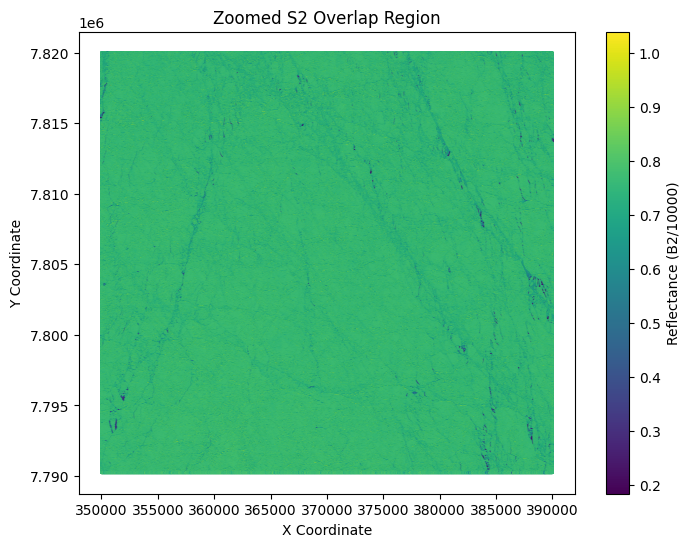

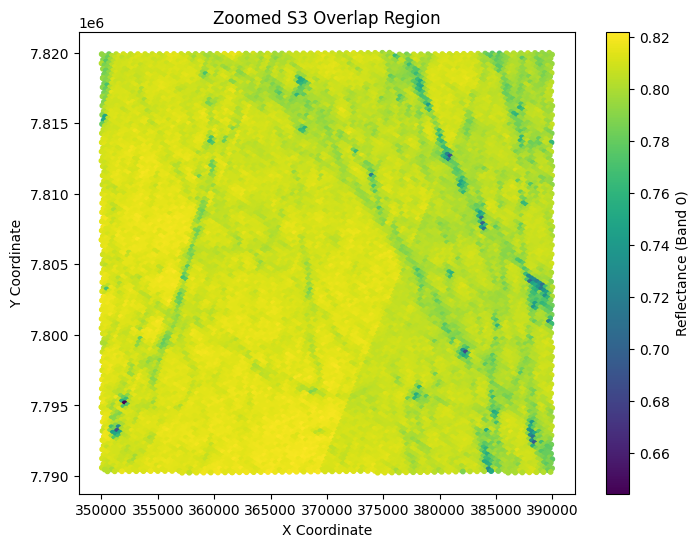

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

save_path = '/content/drive/MyDrive/GEOL0069/2425/Week 5/Regression_application'
s2_data = np.load(save_path+'/s2_zoomed_data.npz')
s2_x = s2_data['x']
s2_y = s2_data['y']
s2_band_data = s2_data['band_data']

s3_data = np.load(save_path+'/s3_zoomed_data.npz')
s3_x = s3_data['x']
s3_y = s3_data['y']
s3_reflectance = s3_data['reflectance']

plt.figure(figsize=(8, 6))
scatter_s2 = plt.scatter(
    s2_x, s2_y,
    c=s2_band_data[:, 2] / 10000,
    cmap='viridis',
    s=1
)
plt.colorbar(scatter_s2, label='Reflectance (B2/10000)')
plt.title('Zoomed S2 Overlap Region')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


plt.figure(figsize=(8, 6))
scatter_s3 = plt.scatter(
    s3_x, s3_y,
    c=s3_reflectance[:, 0],
    cmap='viridis',
    s=10
)
plt.colorbar(scatter_s3, label='Reflectance (Band 0)')
plt.title('Zoomed S3 Overlap Region')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


## Step 2: Label S2 pixels (See week 4 on unsupervised classification)
For the code below, we use K-Means clustering to get the labels of Sentinel-2 image and we will use them to generate part of the training data.

Cluster centers:
 [[7338.76741571 6357.39118654 7685.55652304]
 [6407.05486867 5708.91415423 7042.86164927]]


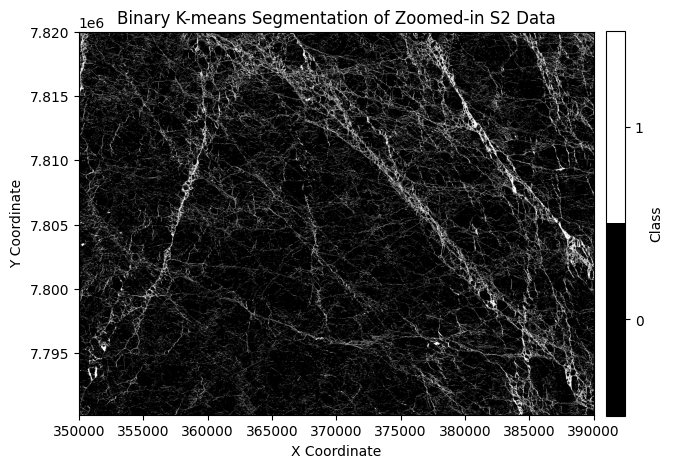

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(s2_band_data)

unique_x = np.sort(np.unique(s2_x))
unique_y = np.sort(np.unique(s2_y))

num_cols = unique_x.size
num_rows = unique_y.size

N = s2_band_data.shape[0]

binary_mask = labels.reshape(num_rows, num_cols)

print("Cluster centers:\n", kmeans.cluster_centers_)
if kmeans.cluster_centers_[0].mean() < kmeans.cluster_centers_[1].mean():
    binary_mask = 1 - binary_mask

plt.figure(figsize=(8, 5))
binary_cmap = ListedColormap(["black", "white"])
plt.imshow(binary_mask, cmap=binary_cmap, origin='upper',
           extent=[unique_x.min(), unique_x.max(), unique_y.min(), unique_y.max()])
plt.colorbar(ticks=[0, 1], label="Class", pad=0.02)
plt.clim(-0.5, 1.5)
plt.title('Binary K-means Segmentation of Zoomed-in S2 Data')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

## Step 3: Find collocated pixels using KDTree
The code constructs a KDTree from S3 coordinates to quickly find the nearest S3 pixel for each S2 data point based on their (x, y) positions. It then groups S2 points by their nearest S3 neighbor and computes an aggregated value (sea ice concentration) for each S3 pixel. In the end, we create a dataset that we could use for ML activities.

The logic of our KDTree is for each Sentinel‑2 pixel to find its nearest Sentinel‑3 pixel, ensuring that every fine-resolution S2 measurement is uniquely assigned to a single coarse-resolution S3 pixel—this approach avoids the pitfalls of using a fixed radius around each S3 pixel, which could potentially miss some S2 pixels or count them more than once. A illustration is shown here.

In [ ]:
from scipy.spatial import KDTree
from collections import defaultdict


s2_points = np.vstack((s2_x, s2_y)).T
s3_points = np.vstack((s3_x, s3_y)).T

tree = KDTree(s3_points)

distances, s3_indices_for_s2 = tree.query(s2_points)

grouped = defaultdict(list)
for s2_idx, s3_idx in enumerate(s3_indices_for_s2):
    grouped[s3_idx].append(s2_idx)

SICavg = np.full(len(s3_points), np.nan)

for s3_idx, s2_indices in grouped.items():
    SICavg[s3_idx] = 1 - np.mean(labels[s2_indices])

In [ ]:
# Plot the distaces as a histogram
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(distances, bins = 100)
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Frequency')
ax.set_title('S2 to nearest S3 distance histogram')
ax.text(0.8, 0.9, f'Mean distance: {np.mean(distances):.2f} m', transform=ax.transAxes, ha='center')
plt.show()

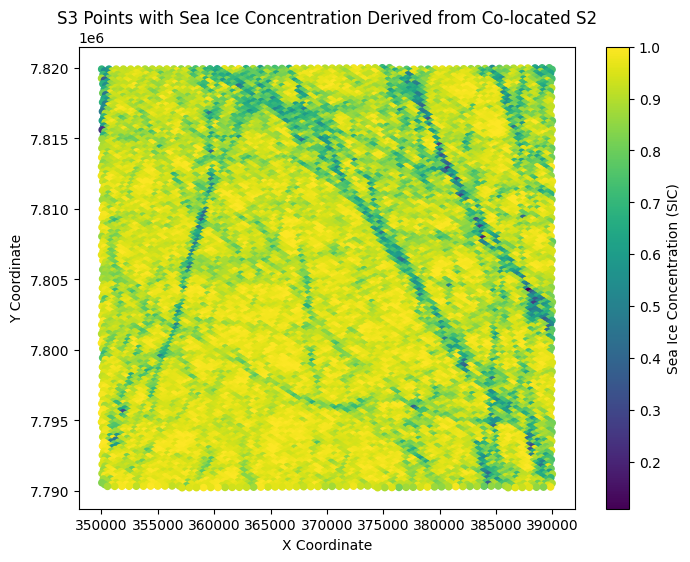

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(s3_points[:, 0], s3_points[:, 1],
                      c=SICavg, cmap='viridis', s=20)
plt.colorbar(scatter, label='Sea Ice Concentration (SIC)')
plt.title("S3 Points with Sea Ice Concentration Derived from Co-located S2")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

In [ ]:
import numpy as np
import pandas as pd


valid_mask = ~np.isnan(SICavg)
X_valid = s3_reflectance[valid_mask, :]
y_valid = SICavg[valid_mask]

n_bands = s3_reflectance.shape[1]
column_names = [f'refl_band_{i+1}' for i in range(n_bands)]
df = pd.DataFrame(X_valid, columns=column_names)
df['SIC'] = y_valid
save_path = '/content/drive/MyDrive/GEOL0069/2425/Week 5/Regression_application'
np.savez(save_path+'/s3_ML_dataset.npz', X=X_valid, y=y_valid)

df.to_csv(save_path+'/s3_ML_dataset.csv', index=False)

print("ML dataset created and saved!")
print("Feature shape:", X_valid.shape)
print("Target shape:", y_valid.shape)


ML dataset created and saved!
Feature shape: (14445, 21)
Target shape: (14445,)
